In [1]:
128,862,1

(128, 862, 1)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense,Flatten,Reshape,Activation,BatchNormalization,Dense,Dropout,Flatten
from tensorflow.keras.layers import LeakyReLU,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [4]:
img_rows = 862     # 431  #
img_cols = 128     # 64   # 32   # 16
img_channels = 1
img_shape = (img_rows, img_cols, img_channels)

z_dim = 1000

In [6]:
def build_generator(img_shape,s_dim):
    model = Sequential()
    model.add(Dense(16*431,input_dim=z_dim))
    model.add(Reshape((16,431,1)))
    model.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64,kernel_size=3,strides=(2,1),padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1,kernel_size=3,strides=(2,1),padding = 'same'))
    model.add(Activation('tanh'))
    return model

In [20]:
model = build_generator(img_shape,1000)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 6896)              696496    
_________________________________________________________________
reshape_4 (Reshape)          (None, 16, 431, 1)        0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 32, 862, 128)      1280      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 862, 128)      512       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32, 862, 128)      0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 64, 862, 64)       73792     
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 862, 64)      

In [ ]:
model.fit(inputs,y)

In [7]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(32,kernel_size=3,strides=2,input_shape = img_shape,padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    return model



In [5]:
def build_gan(generator,discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [6]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss = 'binary_crossentropy',optimizer = Adam(),metrics=['accuracy'])
generator = build_generator(img_shape,z_dim)
discriminator.trainable=False
gan = build_gan(generator,discriminator)
gan.compile(loss = '',optimizer = Adam())

In [11]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations,batch_size,sample_interval):
    (x_train,_),(_,_) = mnist.load_data()
    x_train = x_train/127.5-1.0
    x_train = np.expand_dims(x_train,axis=3)
    
    real = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))
    
    for iteration in range(iterations):
        idx = np.random.randint(0,x_train.shape[0],batch_size)
        imgs = x_train[idx]
        
        z = np.random.normal(0,1,(batch_size,100))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs,real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs,fake)
        d_loss,accuracy = 0.5*np.add(d_loss_real,d_loss_fake)
        
        z = np.random.normal(0,1,(batch_size,100))
        # gen_imgs = generator.predict(z)
        g_loss = gan.train_on_batch(z,real)
        
        if (iteration+1)%sample_interval==0:
            losses.append((d_loss,g_loss))
            accuracies.append(100*accuracy)
            iteration_checkpoints.append(iteration+1)
            
            print("%d [D 손실: %f, 정확도 : %.2f%%]  [G 손실 : %f]"%(iteration+1,d_loss,100*accuracy,g_loss))
            
            sample_images(generator)

In [7]:
def sample_images(generator,image_grid_rows = 4,image_grid_columns=4):
    z = np.random.normal(0,1,(image_grid_rows*image_grid_columns,z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5*gen_imgs+0.5
    fig,axs = plt.subplots(image_grid_rows,image_grid_columns,figsize=(4,4),sharey=True,sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0],cmap='gray')
            axs[i,j].axis('off')
            cnt+=1

1000 [D 손실: 0.442122, 정확도 : 78.12%]  [G 손실 : 1.742972]
2000 [D 손실: 0.510306, 정확도 : 78.12%]  [G 손실 : 1.580287]
3000 [D 손실: 0.496622, 정확도 : 73.83%]  [G 손실 : 1.580957]
4000 [D 손실: 0.451363, 정확도 : 79.30%]  [G 손실 : 1.538196]
5000 [D 손실: 0.429364, 정확도 : 78.52%]  [G 손실 : 1.841252]
6000 [D 손실: 0.431870, 정확도 : 78.52%]  [G 손실 : 1.600901]
7000 [D 손실: 0.454088, 정확도 : 77.73%]  [G 손실 : 1.548303]
8000 [D 손실: 0.406179, 정확도 : 79.30%]  [G 손실 : 1.667692]
9000 [D 손실: 0.473741, 정확도 : 76.56%]  [G 손실 : 1.686198]
10000 [D 손실: 0.452918, 정확도 : 79.30%]  [G 손실 : 1.646054]
11000 [D 손실: 0.435114, 정확도 : 75.78%]  [G 손실 : 1.717572]
12000 [D 손실: 0.438872, 정확도 : 78.52%]  [G 손실 : 1.733224]
13000 [D 손실: 0.427425, 정확도 : 77.73%]  [G 손실 : 1.544612]
14000 [D 손실: 0.425643, 정확도 : 80.86%]  [G 손실 : 1.750184]
15000 [D 손실: 0.394500, 정확도 : 81.25%]  [G 손실 : 1.826147]
16000 [D 손실: 0.370355, 정확도 : 81.25%]  [G 손실 : 1.842312]
17000 [D 손실: 0.404461, 정확도 : 83.98%]  [G 손실 : 1.611307]
18000 [D 손실: 0.373288, 정확도 : 80.47%]  [G 손실 : 1.789065]
1

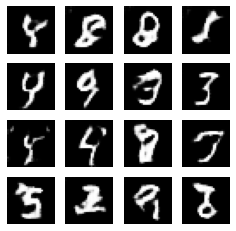

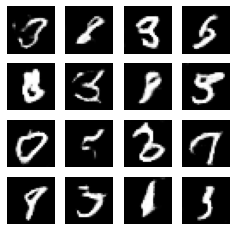

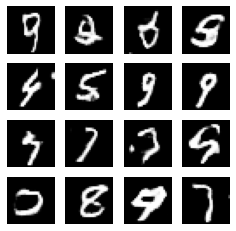

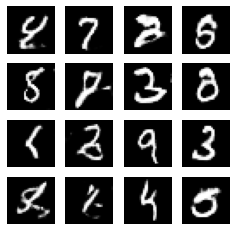

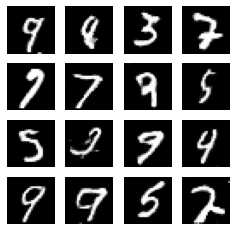

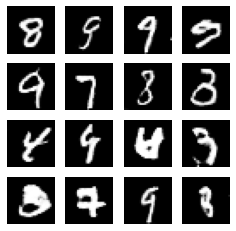

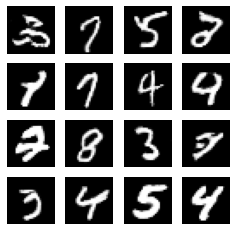

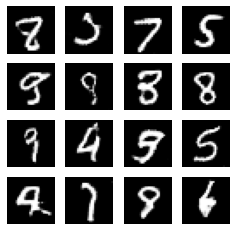

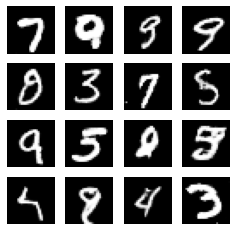

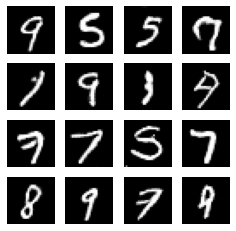

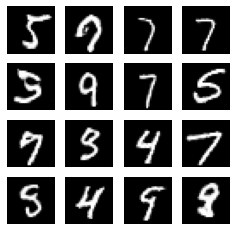

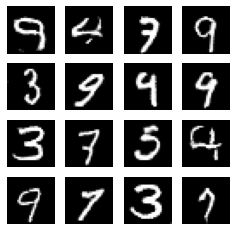

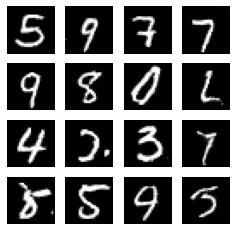

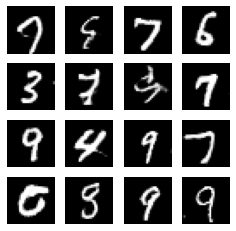

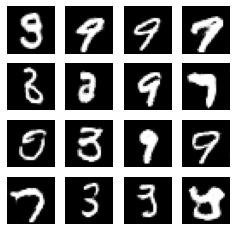

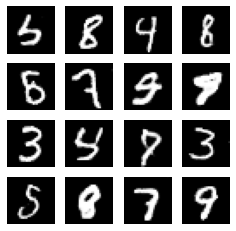

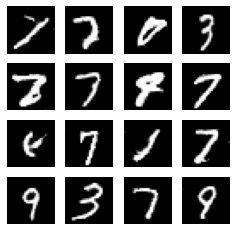

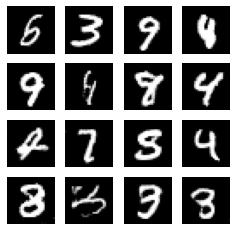

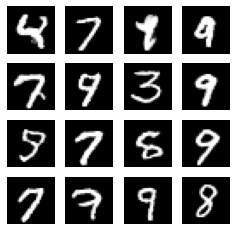

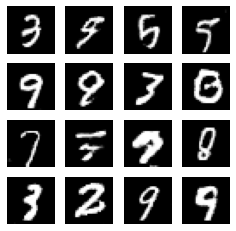

In [12]:
iterations = 20000
batch_size=128
sample_interval = 1000

train(iterations,batch_size,sample_interval)